## Шаг1. Открытие файлов с данными

In [1]:
# !pip install eli5
# !pip install xgboost
# !pip install shap

# подгрузим необходимые библиотеки для работы с данными и отрисовки графиков
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

# подгрузим всё необходимое для работы с моделями
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score 
from sklearn.metrics import recall_score, precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import shap
shap.initjs()
from pickle import dump, load

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None) 

In [2]:
# зададим константу random_state
RAND_ST = 123

In [3]:
# считаем данные
try:
    df_train = pd.read_csv('/datasets/train.csv')
    df_test = pd.read_csv('/datasets/test.csv')
except:
    df_train = pd.read_csv('./datasets/train.csv')
    df_test = pd.read_csv('./datasets/test.csv')

# посмотрим на общую информацию по датафрейму df_train
display(df_train.head(5))
display(df_train.info())
display(df_test.head(5))
display(df_test.info())

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


None

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   5  18888       1     154    85.0    130     80            1     1      0   
1   6  19042       2     170    69.0    130     90            1     1      0   
2   7  20432       1     160    70.0    120     75            1     1      0   
3  10  18133       2     185    94.0    130     90            1     1      0   
4  11  16093       2     170    76.0    120     80            1     1      0   

   alco  active  
0     0       1  
1     0       1  
2     0       0  
3     0       1  
4     0       1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


None

## Шаг 2. Предобработка данных

Для выявления возможных аномальных значений необходимо с помощью метода `'describe'` ознакомится с количественными данными.

In [4]:
print('Обучающуая выборка: ')
df_train.describe()

Обучающуая выборка: 


id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      0.680250      0.572270      0.283484   
min     -150.000000    -70.000000      1.000000      1.000000      0.000000   
25%      120.000000     80.000000      1.000000      1.000000      0.000000   
50%      120.000000     80.000000      1.000000      1.000000      0.000000   
75%      140.000000     90.000000      2.000000      1.000000      0.000000   
max    16020.000000  11000.000000      3.000000      3.000000      1.000000   

               alco        active        cardio  
count  70000.000000  70000.000000  70000.000000  
mean       0.053771      0.803729      0.499700  
std        0.225568      0.397179      0.500003  
min        0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000  
50%        0.000000      1.000000      0.000000  
75%        0.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

In [5]:
print('Тестовая выборка: ')
df_test.describe()

Тестовая выборка: 


id           age        gender        height        weight  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean   50062.686900  19455.528400      1.353733    164.322267     74.120615   
std    28906.167148   2477.840922      0.478136      8.213740     14.341540   
min        5.000000   8865.000000      1.000000     50.000000     10.000000   
25%    24983.250000  17658.000000      1.000000    159.000000     65.000000   
50%    49995.500000  19694.000000      1.000000    165.000000     72.000000   
75%    75232.250000  21320.000000      2.000000    170.000000     82.000000   
max    99997.000000  23705.000000      2.000000    198.000000    183.000000   

              ap_hi         ap_lo   cholesterol          gluc        smoke  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.00000   
mean     130.271300     95.689000      1.368033      1.222700      0.08860   
std      212.501152    163.852598      0.679166      0.566494      0.28417   
min     -130.000000    -90.000000      1.000000      1.000000      0.00000   
25%      120.000000     80.000000      1.000000      1.000000      0.00000   
50%      120.000000     80.000000      1.000000      1.000000      0.00000   
75%      140.000000     90.000000      2.000000      1.000000      0.00000   
max    16020.000000   9100.000000      3.000000      3.000000      1.00000   

               alco        active  
count  30000.000000  30000.000000  
mean       0.055000      0.805733  
std        0.227984      0.395642  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%        0.000000      1.000000  
75%        0.000000      1.000000  
max        1.000000      1.000000

По признакам `ap_lo` и `ap_hi` есть аномальные значения. Скорее всего в значения попали лишние `0`. Обработаем такие аномалии в данных с помощью функций.

In [6]:
def ap_hi(hi):
    if hi < 0:
        return abs(hi)
    elif 1 <= hi <= 2:
        return hi * 100
    elif 3 <= hi <= 25:
        return hi * 10
    elif 270 < hi < 2700:
        return hi // 10
    elif 2700 < hi < 17000:
        return hi // 100
    else:
        return hi
    
    
def ap_lo(lo):
    if lo < 0:
        return abs(lo)
    elif 200 <= lo < 2000:
        return lo // 10
    elif 2000 <= lo < 20000:
        return lo // 100
    else:
        return lo


df_train['ap_hi'] = df_train['ap_hi'].map(ap_hi)
df_train['ap_lo'] = df_train['ap_lo'].map(ap_lo)
df_test['ap_hi'] = df_test['ap_hi'].map(ap_hi)
df_test['ap_lo'] = df_test['ap_lo'].map(ap_lo)

# поменяем местами значения верхнего и нижнего давления где это необходимо
df_train['ap_hi'], df_train['ap_lo'] = np.where(df_train['ap_hi'] < df_train['ap_lo'],
                                                (df_train['ap_lo'], df_train['ap_hi']),
                                                (df_train['ap_hi'], df_train['ap_lo']))
df_test['ap_hi'], df_test['ap_lo'] = np.where(df_test['ap_hi'] < df_test['ap_lo'],
                                                (df_test['ap_lo'], df_test['ap_hi']),
                                                (df_test['ap_hi'], df_test['ap_lo']))

Проверим данные на наличие пропусков

In [7]:
df_train.isna().sum()
df_test.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64

## Шаг 3. EDA

Проведем небольшой исследовательский анализ данных.

<Figure size 1080x648 with 0 Axes>

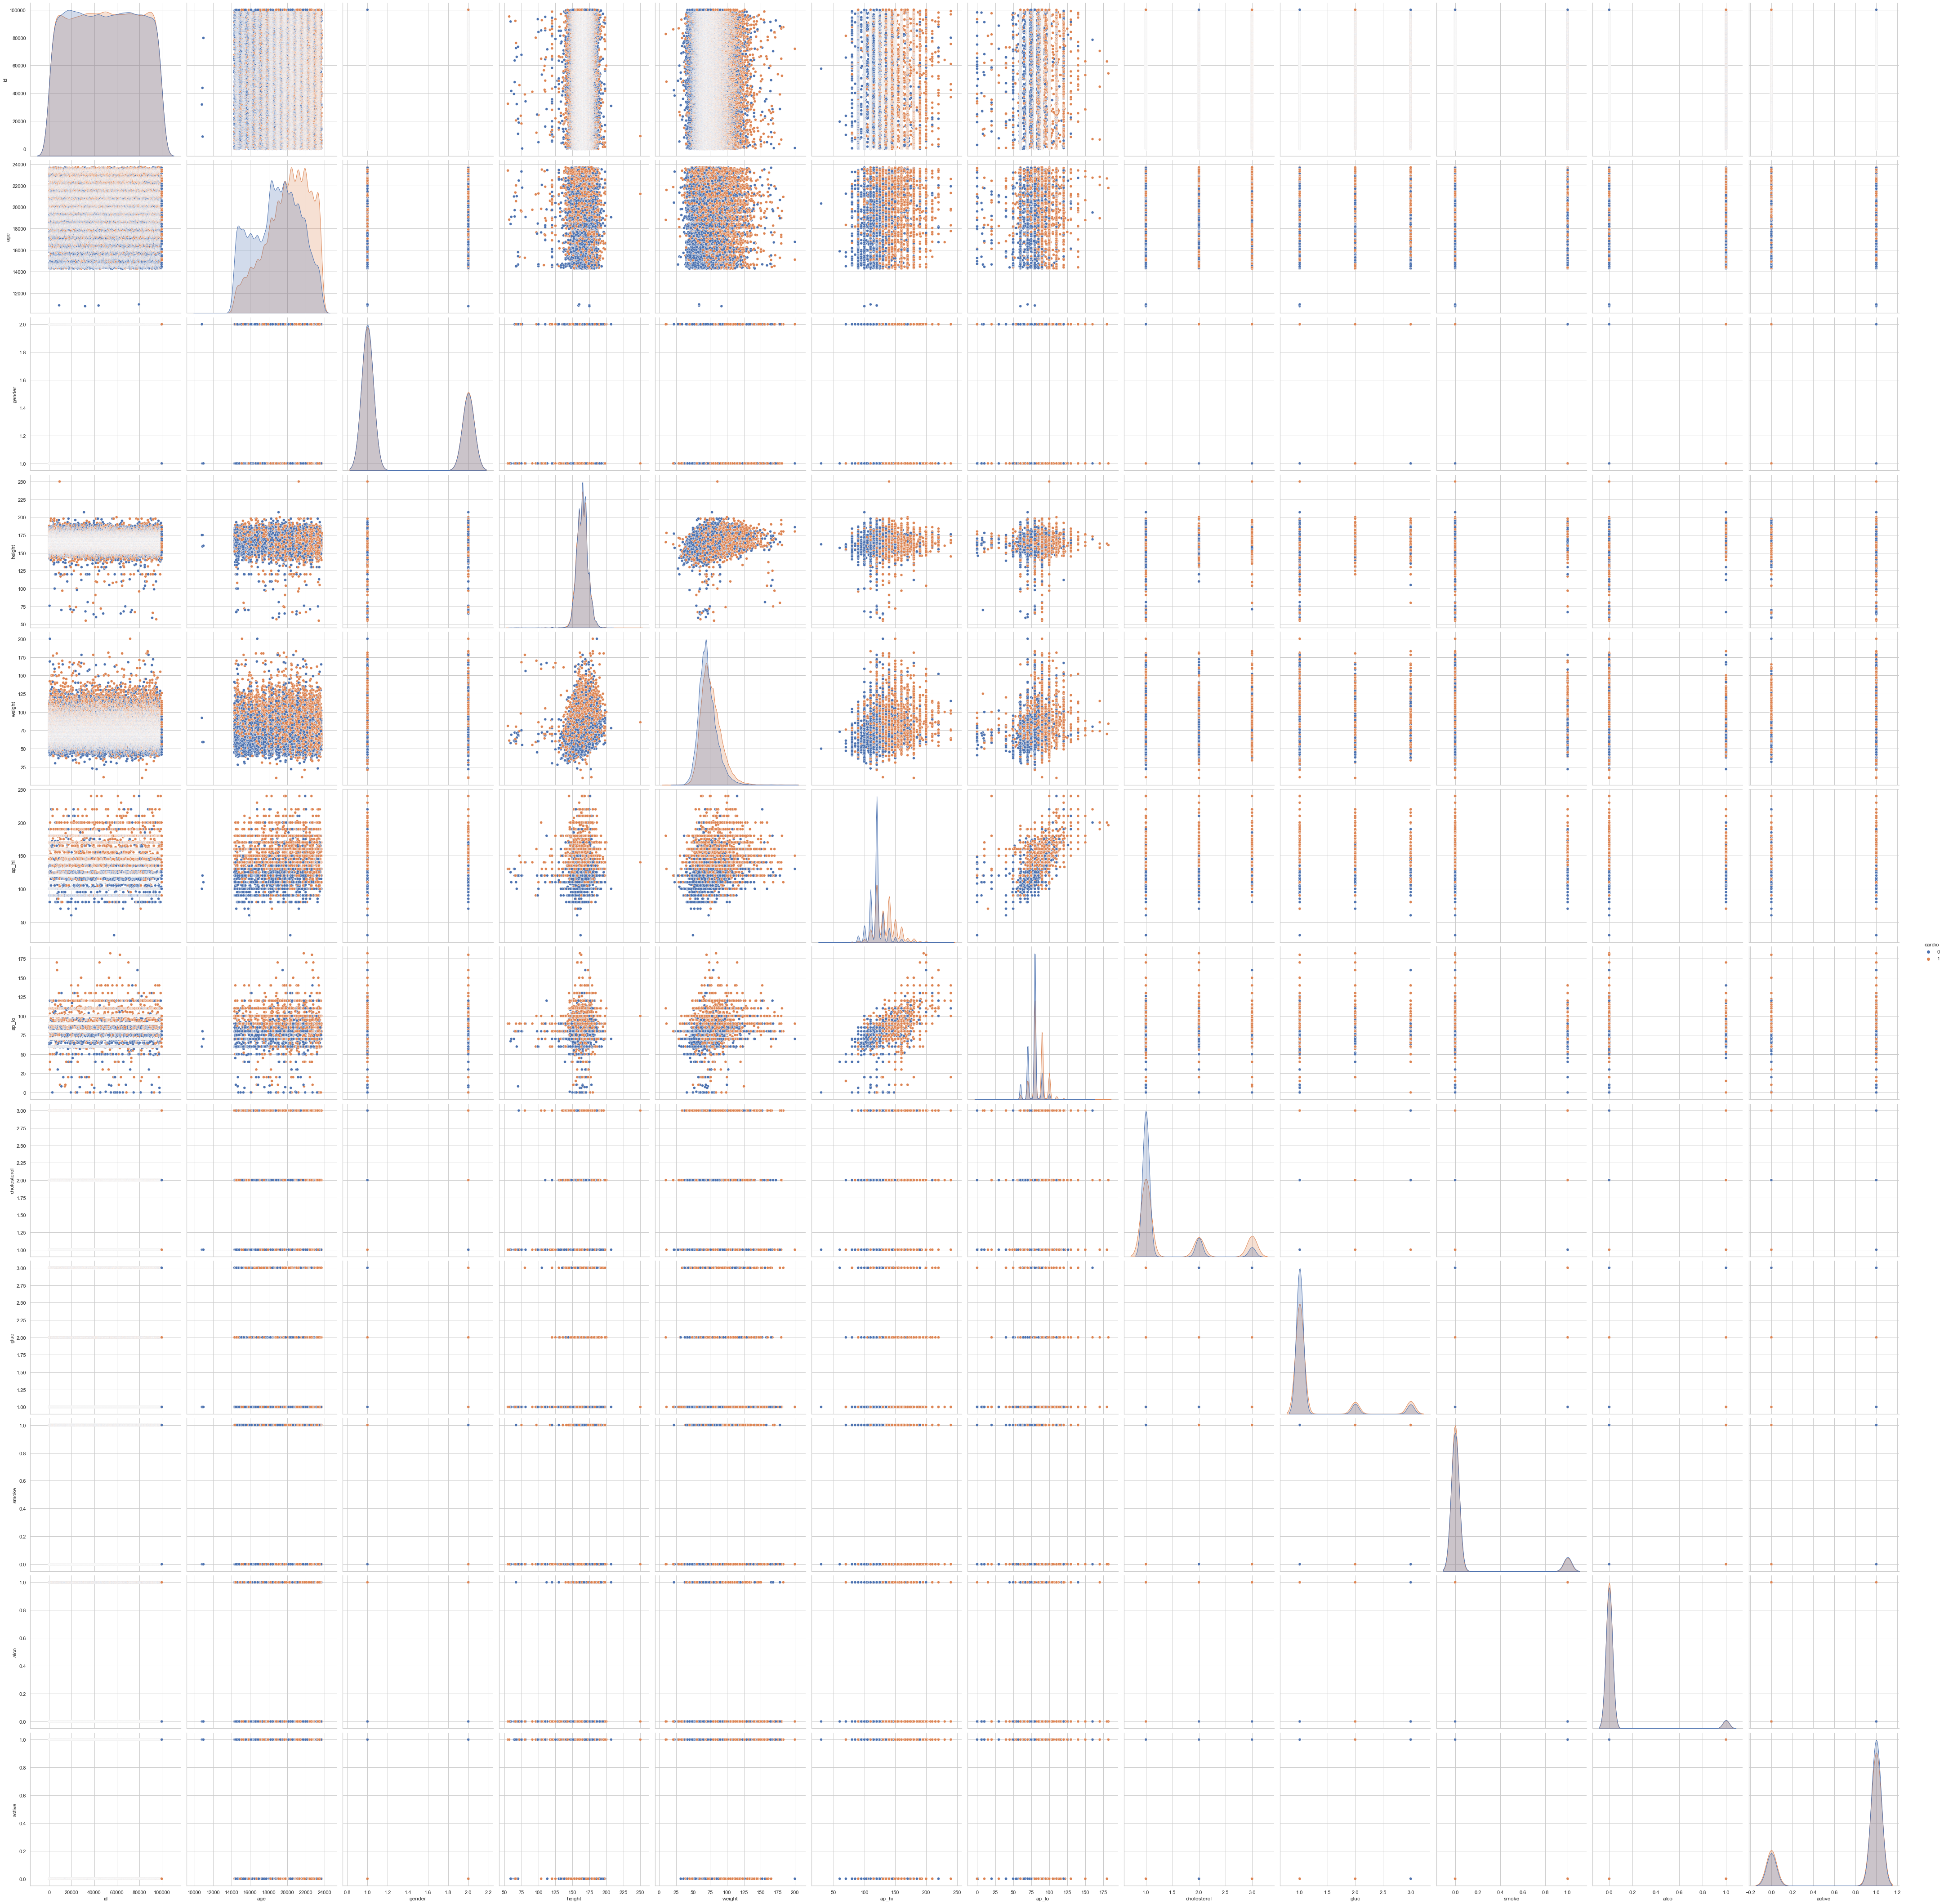

In [8]:
plt.figure(figsize=(15, 9))
sns.pairplot(df_train,  hue='cardio', height=5);

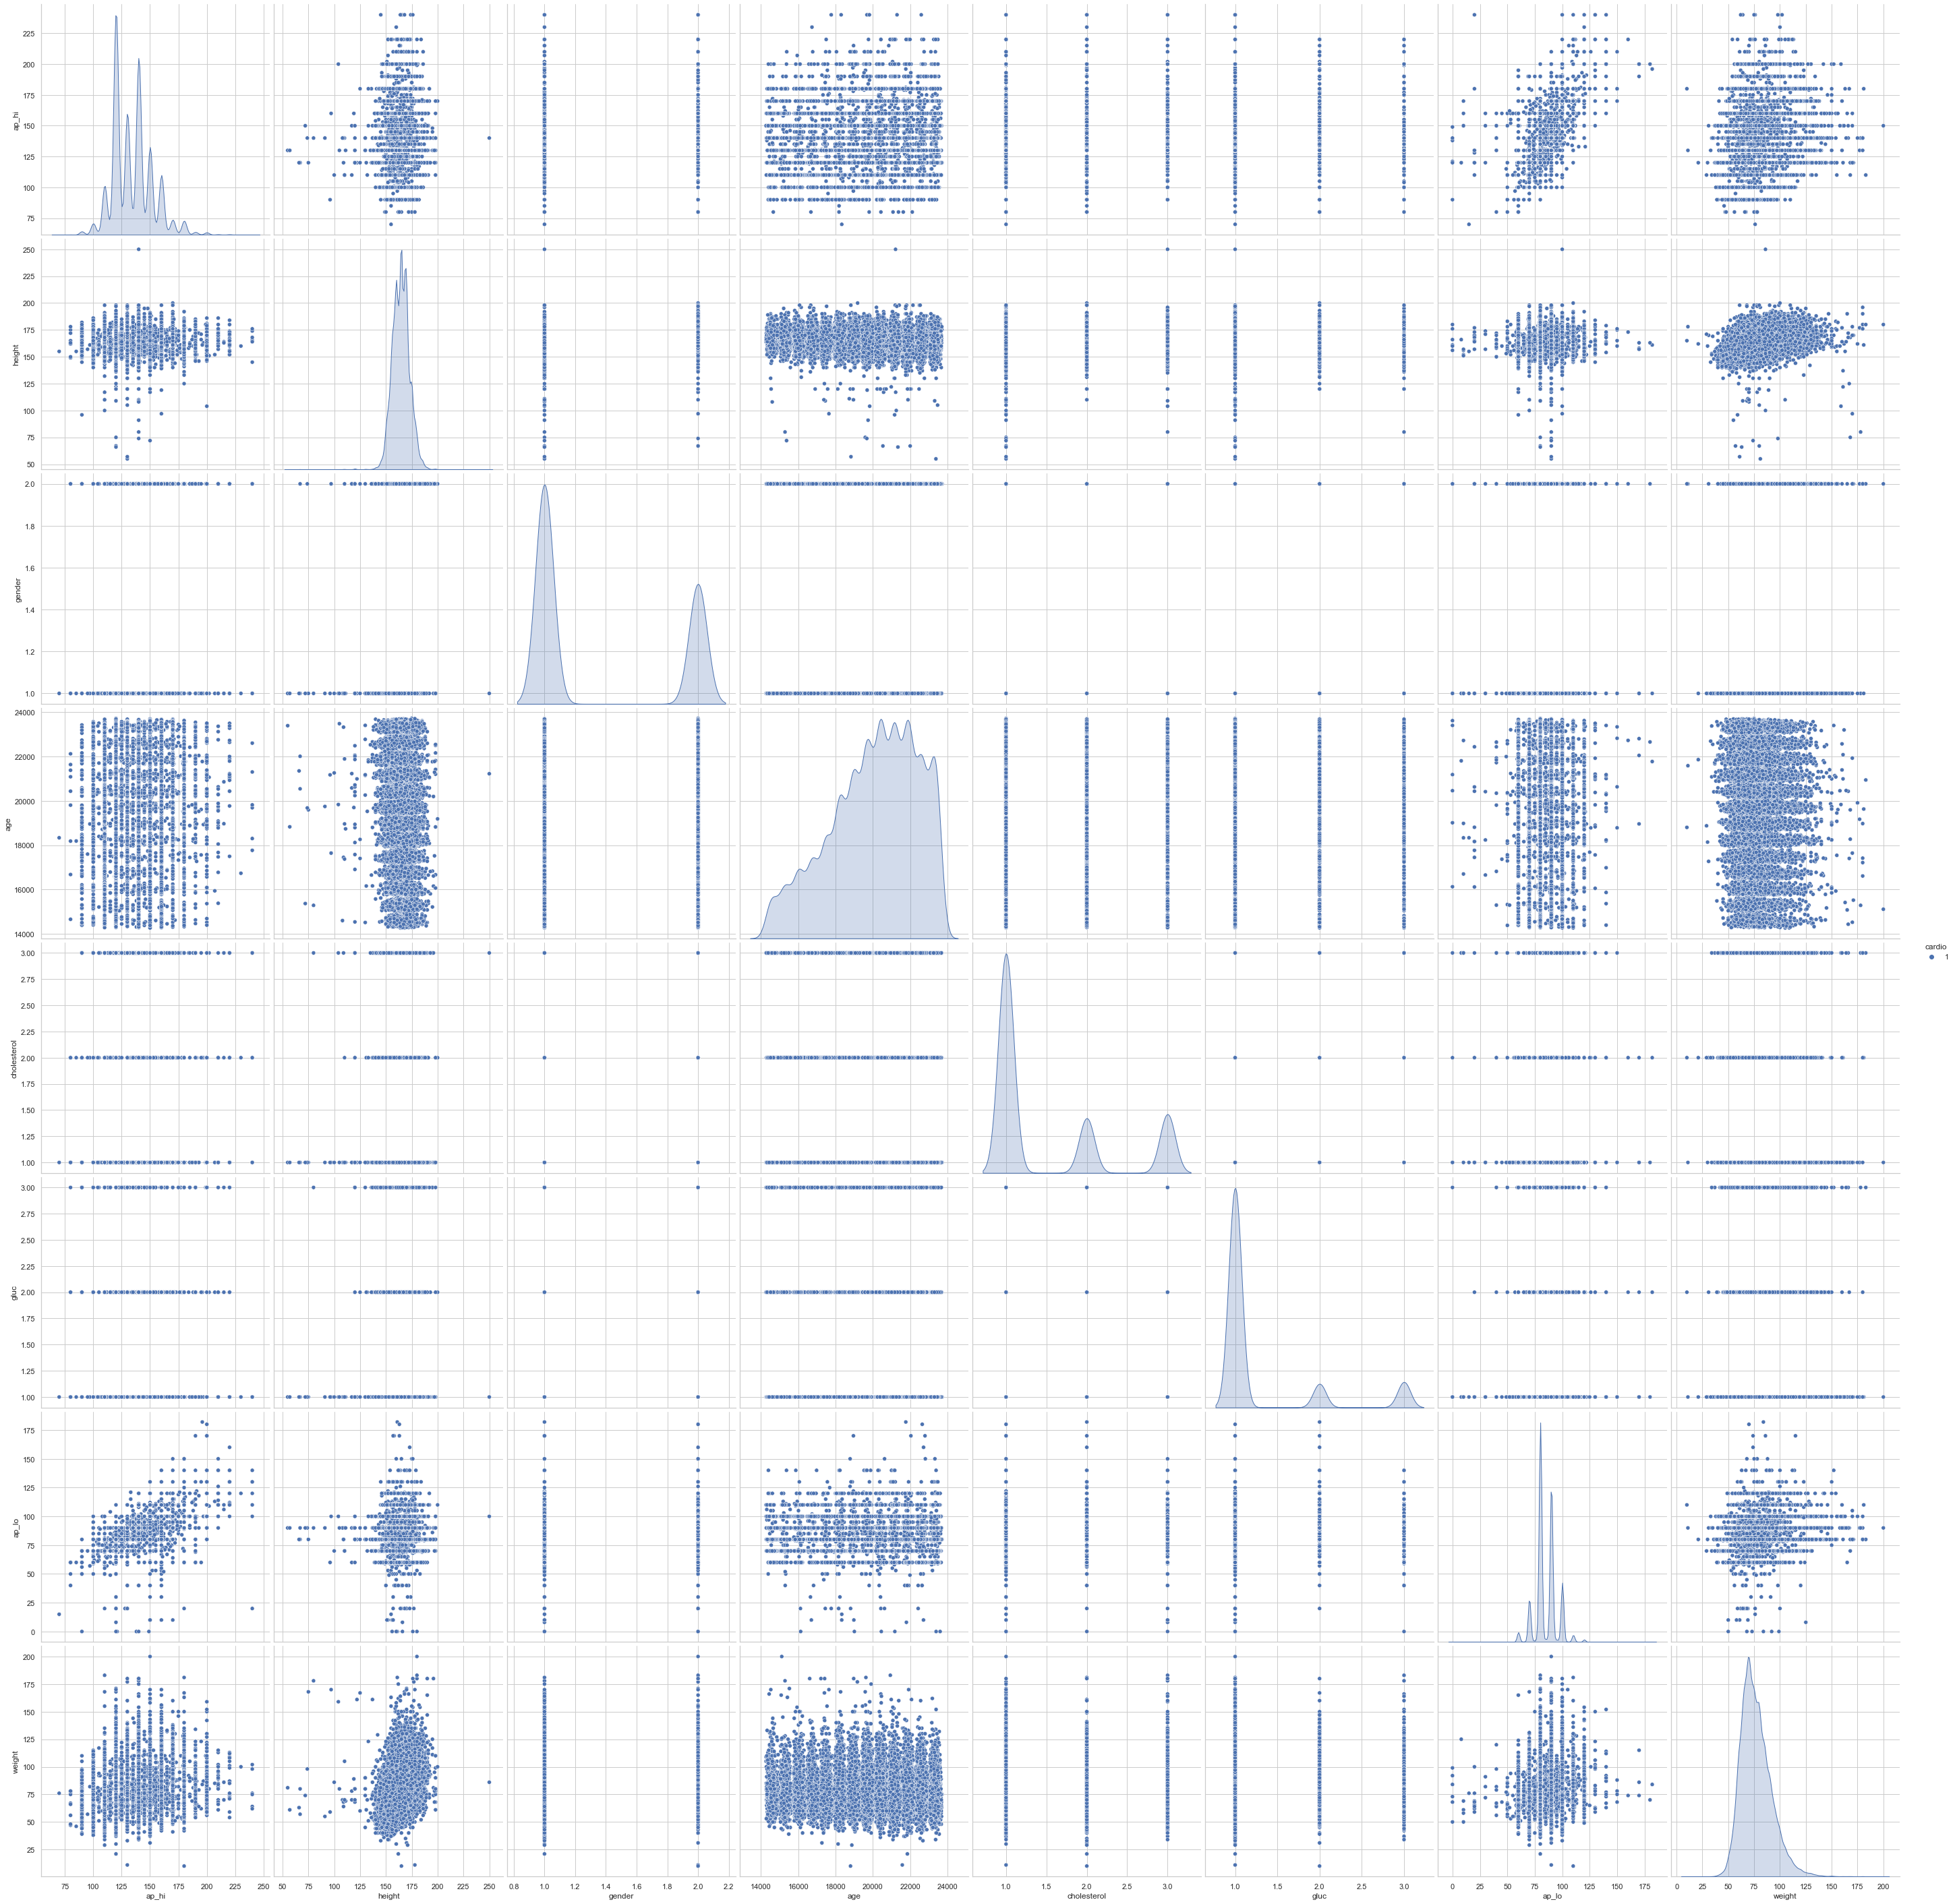

In [9]:
sns.pairplot(df_train[df_train['cardio'] == 1][['ap_hi', 'height', 'gender', 'age', 'cholesterol', 'gluc', 'ap_lo', 'weight', 'cardio']],  hue='cardio', height=5);

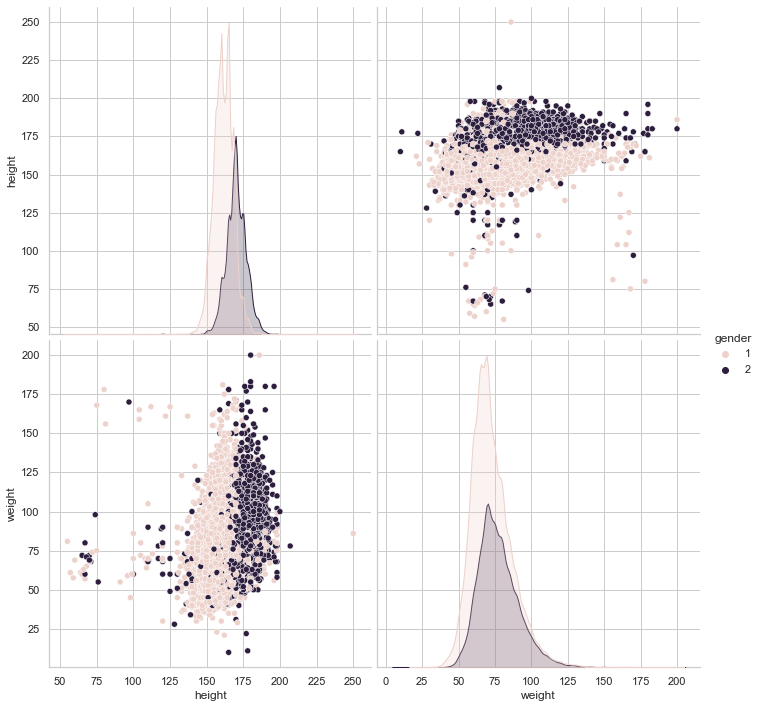

In [10]:
sns.pairplot(df_train[['height', 'weight', 'gender']], hue='gender', height=5)

Из графика видно, что **1** закодированы 'женщины' (так в среднем их рост и вес чуть ниже, чем у мужчин), а **2** - 'мужчины'.

## Шаг 4. Feature Engineering

Рассчитаем индекс массы тела

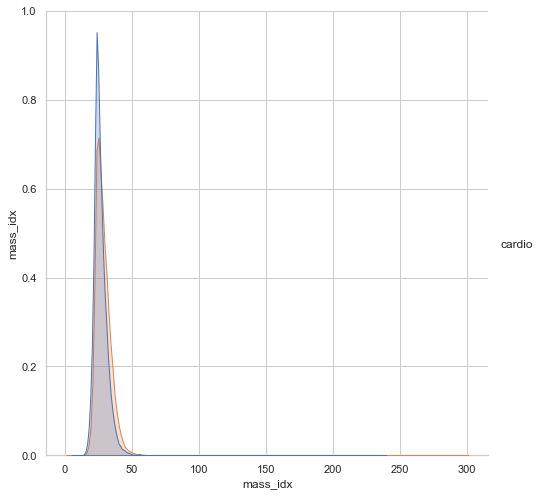

In [11]:
df_train['mass_idx'] = df_train['weight'] / (df_train['height'] / 100)**2 
df_test['mass_idx'] = df_test['weight'] / (df_test['height'] / 100)**2 
sns.pairplot(df_train[['mass_idx', 'cardio']],  hue='cardio', height=7);

Из графика видно что индекс массы тела практически не дает разделения выборки по таргету `cardio`.

Создадим признак `year` с возрастом пациента в годах.

In [12]:
df_train['years'] = (df_train['age'] / 365).round().astype('int')
df_test['years'] = (df_test['age'] / 365).round().astype('int')

# df_train['age_bin'] = pd.cut(df_train['years'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
#                               labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

Из графика видно, что новый признак немного, но все же разделяет выборку по таргету.

Расчитаем среднее артериальное давление.

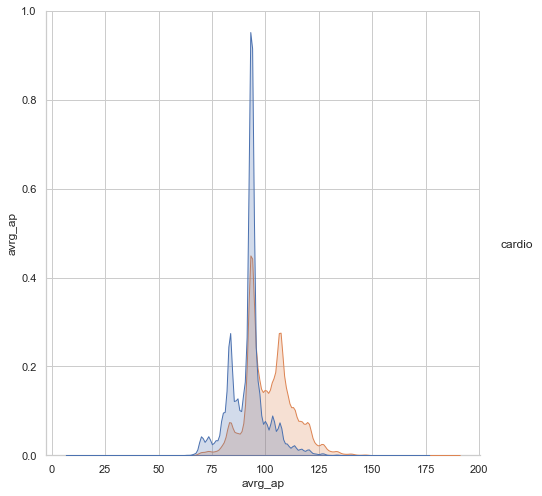

In [13]:
df_train['avrg_ap'] = np.round((2 * df_train['ap_lo'] + df_train['ap_hi']) / 3, 1)
df_test['avrg_ap'] = np.round((2 * df_test['ap_lo'] + df_test['ap_hi']) / 3, 1)
sns.pairplot(df_train[['avrg_ap', 'cardio']],  hue='cardio', height=7)

Из графика видно, что новый признак достаточно разделяет выборки по таргету.

Подсчитаем как наличие холестерина, сахара с учетом артериального давления и возраста может повлиять на риск возникновения ССЗ. 

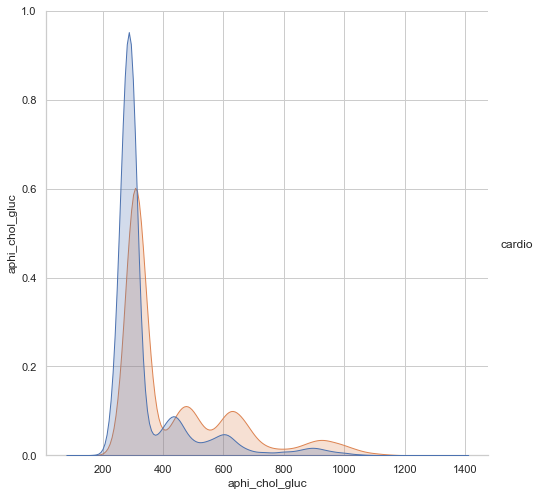

In [14]:
df_train['aphi_chol_gluc'] = (df_train['avrg_ap'] + df_train['years']) * (df_train['cholesterol'] + df_train['gluc'])
df_test['aphi_chol_gluc'] = (df_test['avrg_ap'] + df_test['years']) * (df_test['cholesterol'] + df_test['gluc'])
sns.pairplot(df_train[['aphi_chol_gluc', 'cardio']],  hue='cardio', height=7);

Определим степени артериальной гипртензии

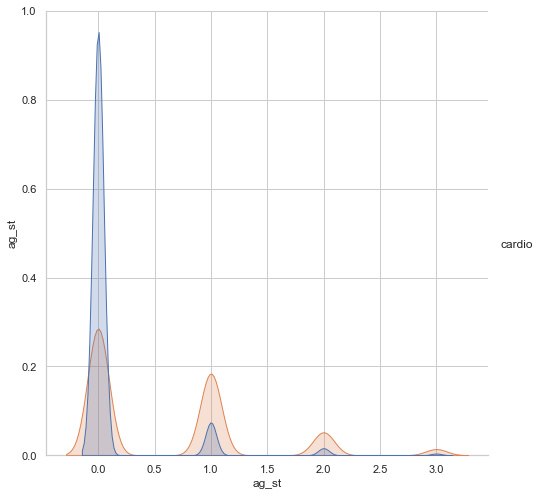

In [15]:
def ag_step(ap_sis):
    if ap_sis < 140:
        return 0
    elif 140 <= ap_sis < 160:
        return 1
    elif 160 <= ap_sis < 180:
        return 2
    elif ap_sis >= 180:
        return 3
    else:
        return 4
    
df_train['ag_st'] = df_train['ap_hi'].map(ag_step) 
df_test['ag_st'] = df_test['ap_hi'].map(ag_step) 
sns.pairplot(df_train[['ag_st', 'cardio']],  hue='cardio', height=7);

Новый признак `ag_st` хорошо разделяет выборку по таргету.

Расчитаем статус жизни

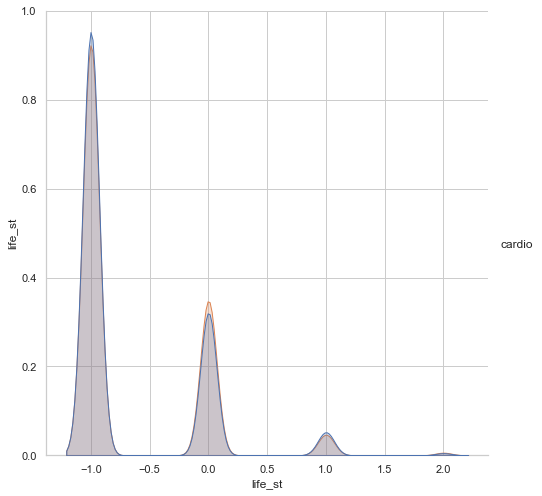

In [16]:
df_train['life_st'] = df_train['alco'] + df_train['smoke'] - df_train['active']
df_test['life_st'] = df_test['alco'] + df_test['smoke'] - df_test['active']
sns.pairplot(df_train[['life_st', 'cardio']],  hue='cardio', height=7);

Из графика видно что статус жизни пациента (влияние на фактор риска ССЗ образа жизни) не дает никакого разделения выборки по таргету `cardio`. Данные факторы практически не влияют на риск ССЗ исходя из представленных данных. Вряд ли признак `life_st` будет полезен для модели.

Расчитаем риск ССЗ с учетом возраста, среднего артериального давления и показатедя `aphi_chol_gluc`.

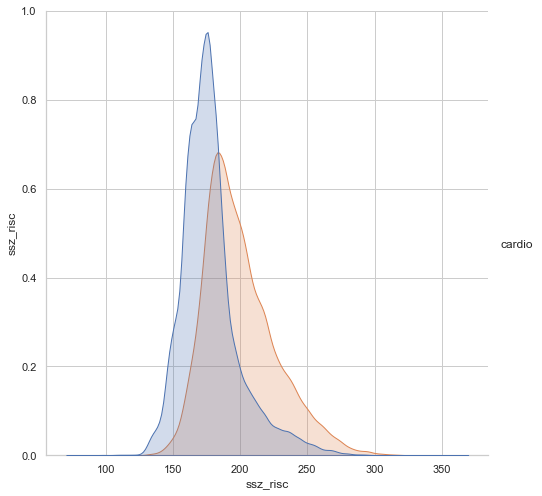

In [17]:
df_train['ssz_risc'] = (df_train['years'] + df_train['avrg_ap'] + df_train['aphi_chol_gluc'] // 10)
df_test['ssz_risc'] = (df_test['years'] + df_test['avrg_ap'] + df_test['aphi_chol_gluc'] // 10)
sns.pairplot(df_train[['ssz_risc', 'cardio']], hue='cardio', height=7);

## Шаг 5. Подготовка и разбивка данных для обучения моделей

На данном этапе подготовим необходимые числовые и категориальные признаки, которые будут использованы для обчуения моделей.
Из общего списка будeт исключен признак `['id']`, так как данный признак не несёт какой-либо значимой информации.

Так же для использования логистической регрессии важно привести все числовые признаки (не бинарные) к одному масштабу с помощью метода **StandardScaler**.

Для категориальных признаков будет применен метод кодирования **One-Hot-Encoding**.

In [18]:
# создадим список числовых признаков для масштабирования
num_columns = ['height', 'weight', 'ap_hi', 'ap_lo', 'mass_idx', 'avrg_ap', 'years']

# num_columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'aphi_chol_gluc',
#                'mass_idx', 'ball_risk']

# создадим список категориальных признаков для OHE
cat_columns = ['cholesterol', 'gluc', 'gender', 'smoke', 'alco', 'active']

# создадим список биноминальных признаков 
# bin_columns = []

# разделим данные на признаки и таргет в обучающей и тестовой выборке
features = num_columns + cat_columns
X_train = df_train[features].copy()
# X_test =  df_test[features].copy()
y_train = df_train['cardio'].copy()

# препроцессинг (масштабирование) числовых признаков
scale_transformer = StandardScaler()

# препроцессинг (кодирование) категориальных признаков
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# общий препроцессинг числовых и категориальных признаков:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scale_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ])

## Шаг 6. Обучение моделей

После обучения моделей с использованием кросс-валидации на 5-и фолдах для усреднения метрик запишем и выведем резльтаты в итоговой таблице. Определим лучшую модель для дальнейшей работы.

In [19]:
# определим список моделей для обучения
model_list = [('RF_model', RandomForestClassifier(random_state=RAND_ST, n_jobs=-1)),
            ('LR_model', LogisticRegression(random_state=RAND_ST, n_jobs=-1)),
            ('XGB_model', XGBClassifier(random_state=RAND_ST, n_jobs=-1))]
# определим кол-во разбиений обучающей выборки для кросс-валидации
# используя так же параметр shuffle чтобы быть уверенными в случайном распределении данных:
kfolds = 5
split = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=RAND_ST)

# выполним в цикле препроцессинг, обучение, предсказание
# и расчет метрик для каждой модели
# а так же запишем все метрики в общую таблицу
# для этого для начала определим переменные
# cols_for_total_table=['Models name', 'Accuracy', 'F1', 'Recall', 'Precision', 'ROC_AUC']
name_list = []
accuracy_list = []
f1_list = []
recall_list = []
precision_list = []
roc_auc_list = []

for name, model in model_list:
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # получим результаты по каждой модели:
    results = cross_validate(model_pipeline, 
                                 X_train, y_train, 
                                 cv=split,
                                 scoring=['accuracy','f1','recall','precision','roc_auc'],
                                 n_jobs=-1)
    # запишем средние значения расчитанных метрик 
    # на кросс-валидации в подготовленные заранее списки
    name_list.append(name)
    accuracy_list.append(results.get('test_accuracy').mean())
    f1_list.append(results.get('test_f1').mean())
    recall_list.append(results.get('test_recall').mean())
    precision_list.append(results.get('test_precision').mean())
    roc_auc_list.append(results.get('test_roc_auc').mean())

# запишем все данные в общую таблицу и выведем результаты 
total_table = pd.DataFrame({
    'Model name':name_list,
    'Accuracy':accuracy_list,
    'F1':f1_list,
    'Recall':recall_list,
    'Precision':precision_list,
    'ROC-AUC':roc_auc_list
})
display(total_table)

Model name  Accuracy        F1    Recall  Precision   ROC-AUC
0   RF_model  0.707429  0.704827  0.699048   0.710731  0.765039
1   LR_model  0.729700  0.713469  0.673518   0.758550  0.793574
2  XGB_model  0.732214  0.721992  0.695903   0.750179  0.797727

Лучшие метрики показала модель `**XGB_model**`. Попробуем с помощью GridSearchCV подобрать оптимальные гиперпараметры.

In [20]:
results

{'fit_time': array([11.61882305, 11.6138227 , 11.52658153, 11.60393429,  5.20613933]),
 'score_time': array([0.21546268, 0.20040917, 0.21252155, 0.20031142, 0.1099987 ]),
 'test_accuracy': array([0.72685714, 0.73364286, 0.73678571, 0.73092857, 0.73285714]),
 'test_f1': array([0.71505216, 0.72477674, 0.72460952, 0.72023765, 0.7252828 ]),
 'test_recall': array([0.68591851, 0.70182962, 0.69296741, 0.69311035, 0.70568897]),
 'test_precision': array([0.74677043, 0.74927514, 0.75927956, 0.7495749 , 0.74599577]),
 'test_roc_auc': array([0.79167787, 0.80085622, 0.80088975, 0.79802469, 0.79718449])}

In [22]:
# param_grid = {
#     'XGB_model__learning_rate': [*np.arange(0.01, 0.5, 0.01)],
#     'XGB_model__max_depth': [2, 3, 4, 5],
#     'XGB_model__n_estimators': [*range(50, 250, 10)]
# }
# 
# XGB_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('XGB_model', XGBClassifier(random_state=RAND_ST, n_jobs=-1))])
# grid = GridSearchCV(XGB_model_pipeline, param_grid=param_grid, cv=5, scoring = 'roc_auc', n_jobs=-1)
# grid.fit(X_train, y_train)
# # pr_prob = grid.predict_proba(X_test)[:,1]
# # # сохранение предсказаний в файл
# # output = pd.DataFrame({'id': df_test['id'],
# #                        'cardio': pr_prob})
# # output.to_csv('submission.csv', index=False)
# display(grid.best_score_)
# display(grid.best_params_)
# feat_imp = grid.best_estimator_.named_steps['XGB_model'].feature_importances_
# sorted(list(zip(feat_imp, X_train.columns)), reverse=True)

Обучим модель XGBClassifier

In [23]:
X = df_train.drop(['id', 'cardio'], axis=1)
y = df_train['cardio'].copy()
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RAND_ST)

balance_ratio = ((len(y_tr) - y_tr.sum()) / y_tr.sum()).round(2)

clf = XGBClassifier(random_state=RAND_ST, n_jobs=-1,n_estimators=100, max_depth=5, learning_rate=0.063)
clf.fit(X_tr, y_tr)
predictions = clf.predict(X_val)
proba_valid = clf.predict_proba(X_val)
proba_one_valid = proba_valid[:, 1]
print(roc_auc_score(y_val, proba_one_valid), accuracy_score(y_val, predictions))
pd.DataFrame(classification_report(y_val, proba_one_valid>0.5, output_dict=True)).transpose()

0.8017539466951662 0.7351428571428571


precision    recall  f1-score       support
0              0.714807  0.782981  0.747343   8755.000000
1              0.759798  0.687250  0.721705   8745.000000
accuracy       0.735143  0.735143  0.735143      0.735143
macro avg      0.737302  0.735116  0.734524  17500.000000
weighted avg   0.737290  0.735143  0.734531  17500.000000

In [ ]:
# X_val

In [ ]:
# # !pip install tensorflow
# # 
# import tensorflow as tf
# from tensorflow import keras
# from sklearn.metrics import confusion_matrix, classification_report
# 
# scale = StandardScaler()
# 
# X_tr_sc = scale.fit(X_tr).transform(X_tr)
# X_val_sc = scale.transform(X_val)
# 
# model=keras.Sequential([
# keras.layers.Dense(20,input_shape=(15,),activation='relu'),
# keras.layers.Dense(1,activation='sigmoid')
# ])
# model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['AUC', 'accuracy'])
# 
# model.fit(X_tr_sc,y_tr,epochs=100)
# 
# print()
# print(model.evaluate(X_val_sc,y_val))
# print()
# ypred= model.predict(X_val_sc)
# ypred = np.round(ypred)
# print()
# print(classification_report(y_val,ypred))

## Шаг 7. Сохранение модели

In [25]:
X_te = df_test.drop(['id'], axis=1)
test_predict = clf.predict_proba(X_te)[:, 1]
display(test_predict)
# сохранение предсказаний в файл
output = pd.DataFrame({'id': df_test['id'],
                       'cardio': test_predict})
output.to_csv('submission.csv', index=False)

array([0.46790338, 0.55972856, 0.41897723, ..., 0.46730015, 0.32303947,
       0.7016727 ], dtype=float32)

In [ ]:
# X_te = df_test.drop(['id'], axis=1)
# X_te_sc = scale.transform(X_te)
# test_predict = model.predict(X_te_sc).reshape(1,-1)
# display(test_predict[0])
# 
# # сохранение предсказаний в файл
# output = pd.DataFrame({'id': df_test['id'],
#                        'cardio': test_predict[0]})
# output.to_csv('submission.csv', index=False)

In [ ]:
with open('./Streamlit prod/model_cardio_04_03_23.pcl', 'wb') as file_out:
    dump(clf, file_out)

## Шаг 8. Определение важности признаков

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


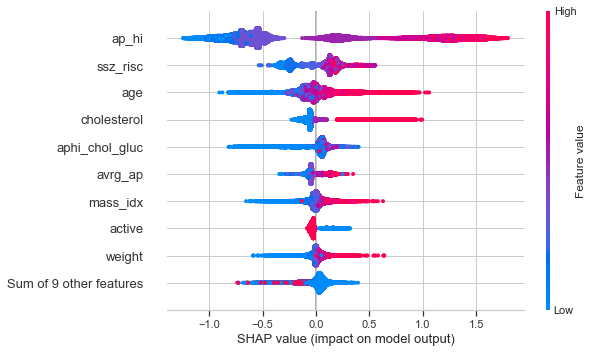

In [26]:
# display(sorted(list(zip(clf.feature_importances_, X_val.columns)), reverse=True))

# получение shap-значений
explainer = shap.Explainer(clf)
shap_values = explainer(X_tr)

shap.plots.beeswarm(shap_values)

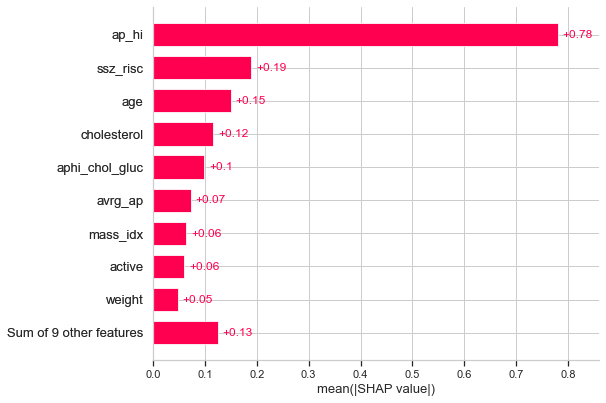

In [27]:
shap.plots.bar(shap_values)

## Дополнительная работа (работа с PCA)

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=RAND_ST)

scale = StandardScaler()
X_tr_sc = scale.fit_transform(X_tr)
X_val_sc = scale.fit_transform(X_val)
X_pca = pca.fit_transform(X_tr_sc)
X_val_pca = pca.fit_transform(X_val_sc)
print("Форма исходного массива: {}".format(str(X_tr_sc.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_pca.shape)))

Форма исходного массива: (52500, 18)
Форма массива после сокращения размерности: (52500, 3)


<AxesSubplot:>

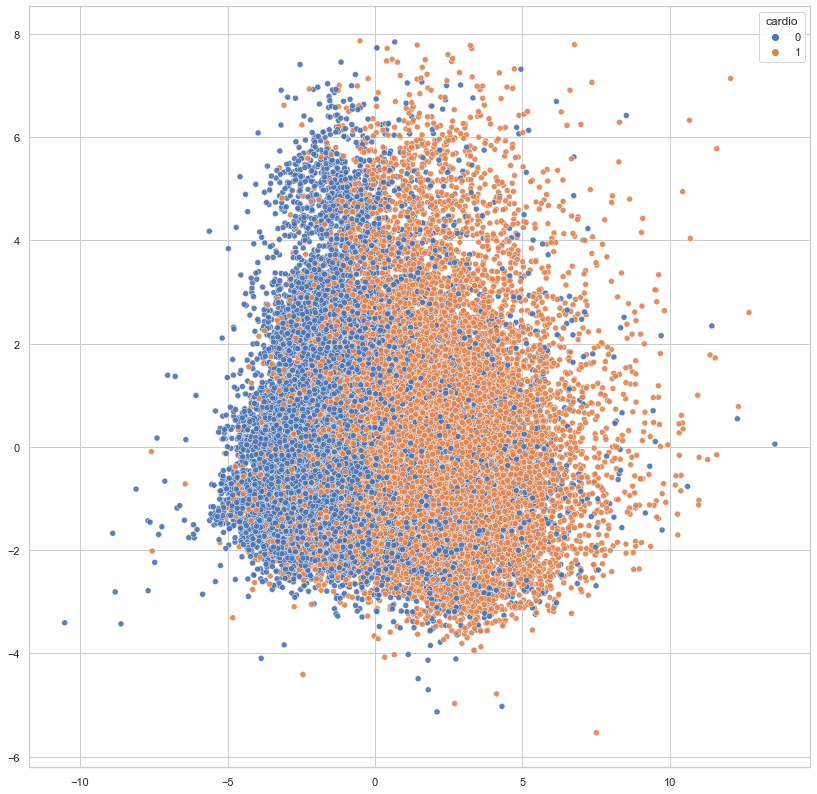

In [29]:
plt.figure(figsize=(14, 14))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_tr, alpha=0.9)

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


Text(0, 0.5, 'Главные компоненты')

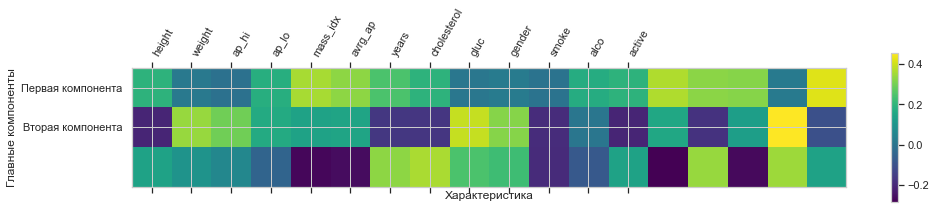

In [30]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["Первая компонента", "Вторая компонента"])
plt.colorbar()
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60, ha='left')
plt.xlabel("Характеристика")
plt.ylabel("Главные компоненты")